# Intro

This notebook implements a Neuro Style Transfer algorithm as taught by Andrew Ng, however, utilizing TensorFlow 2. 

It was a great exercise to make use of the tutorial provided by the [official Tensorflow site](https://www.tensorflow.org/tutorials/generative/style_transfer) in order to transform the AndrewNG assignment.

**What can be seen here**
*   Transfer Learning retrieving several intermediate layer outputs
*   Updating the input of a CNNneuro network as opposed to weights as usual (to generate new image)
*   Use of @tf.function() and tf.GradientTape for automatic differantiation







# Setup

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [2]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [3]:
cd /content/drive/My Drive/Colab Notebooks/NeuroStyleTransfer

/content/drive/My Drive/Colab Notebooks/NeuroStyleTransfer


In [0]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.applications.vgg19 import VGG19 as PretrainedModel, preprocess_input

import numpy as np
import imageio as im
import matplotlib.pyplot as plt

import utils
from PIL import Image

# INPUTS

Text(0.5, 1.0, 'Content Image')

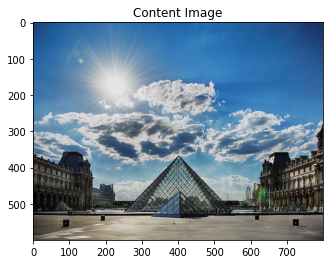

In [5]:
c_content = im.imread('images/louvre.jpg')
plt.imshow(c_content)
plt.title('Content Image')

Text(0.5, 1.0, 'Style Image')

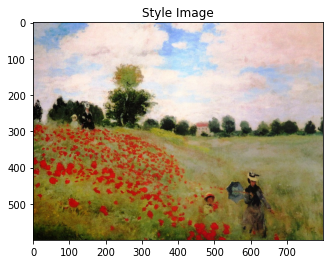

In [6]:
c_style = im.imread('images/monet_800600.jpg')
plt.imshow(c_style)
plt.title('Style Image')

In [0]:
# Import the images and prepare as expected by VGG
import imageio as im
c_content = im.imread('images/louvre.jpg')
c_content = utils.reshape_and_normalize_image(c_content)

c_style = im.imread('images/monet_800600.jpg')
c_style = utils.reshape_and_normalize_image(c_style)

initial_noisy_image = utils.generate_noise_image(c_content)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


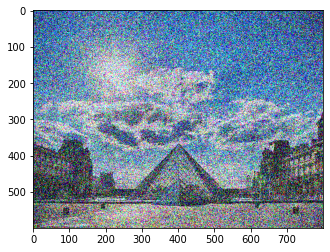

In [9]:
plt.imshow(initial_noisy_image[0])

# Create Model

In [0]:
from tensorflow.keras.models import Model

In order to generate an image that has the content of one image and the style of another image we need to get the activations of intermidiate layers. 

For the content costs we need one layer and for the style layer several layers.

## Style Cost
The goal is to minimize the distance between the Gram matrix of the "style" image S and the gram matrix of the "generated" image G. 
* For a single hidden layer $a^{[l]}$.  
* The corresponding style cost for this layer is defined as: 

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum _{i=1}^{n_C}\sum_{j=1}^{n_C}(G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2 $$

* $G_{gram}^{(S)}$ Gram matrix of the "style" image.
* $G_{gram}^{(G)}$ Gram matrix of the "generated" image.
* This cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$



## The combined the style costs
 for multiple layers can be calculated as follows:

$$J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G)$$

where the values for $\lambda^{[l]}$ are given in `STYLE_LAYERS`. 


## Content Cost Function
We will define the content cost function as:

$$J_{content}(C,G) =  \frac{1}{4 \times n_H \times n_W \times n_C}\sum _{ \text{all entries}} (a^{(C)} - a^{(G)})^2$$

* Here, $n_H, n_W$ and $n_C$ are the height, width and number of channels of the hidden layer you have chosen, and appear in a normalization term in the cost. 

In [0]:
# Content layer where will pull our feature maps
content_layers = ['block5_conv2'] 

# Style layer of interest
style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [0]:
# Define the model with the intermediate outputs needed

def vgg_layers(layer_names):
  vgg = PretrainedModel(include_top = False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = Model([vgg.input], outputs)

  return model

In [0]:
def gram_matrix(A):
    """
    Argument:
    Hidden Layer Activations
    """
    A = tf.squeeze(A, axis=0)
    n_H, n_W, n_C =  A.get_shape().as_list()
    A = tf.reshape(A, shape=[n_C, n_H*n_W])

    ### START CODE HERE ### (≈1 line)
    GA = tf.matmul(A, A, transpose_a=False, transpose_b=True)
    ### END CODE HERE ###
    
    return GA

# Extract style and content
Build a model that returns the style and content tensors.

In [0]:
class StyleContentModel(Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)

  def call(self, inputs):

    inputs = inputs
    outputs = self.vgg(inputs)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])
    
    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

# Get the targets

In [0]:
tf.keras.backend.set_floatx('float64')

In [18]:
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(c_style)['style']
content_target = extractor(c_content)['content']

80142336/80134624 [==============================] - 1s 0us/step


# Variable and Loss Functions

In [0]:
'''Try with a noisy version''' 
image = tf.Variable(initial_noisy_image, dtype=tf.float64, trainable=True)

In [0]:
opt = tf.optimizers.Adam(learning_rate=2, beta_1=0.99, epsilon=1e-1)

In [0]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [0]:
def style_content_loss(outputs, alpha = 45, beta = 10):
  style_outputs = outputs['style']
  content_outputs = outputs['content']
  
  '''Content Cost'''
  layer_name = content_layers[0]
  m, n_H, n_W, n_C = content_outputs[layer_name].get_shape().as_list()
  
  content_loss = (1/(4*n_H*n_W*n_C))*tf.reduce_sum(
      tf.square(tf.subtract(content_target[layer_name],
      content_outputs[layer_name])))
  
  '''Style Cost'''
  style_loss = 0
  for layer_name, coeff in STYLE_LAYERS:
    
    m, n_H, n_W, n_C = style_outputs[layer_name].get_shape().as_list()  
    GG = gram_matrix(style_outputs[layer_name])
    GS = gram_matrix(style_targets[layer_name])

    style_loss_layer = (1/(4*np.square(n_C)*np.square(n_H*n_W)))*tf.reduce_sum(tf.square(tf.subtract(GS, GG)))
    style_loss += coeff*style_loss_layer 
    '''THE STYLE LOSS SEEMS VERY LARGE'''
        
  loss = alpha*content_loss + beta*style_loss

  return loss

## Add Total variation loss
Link: [https://www.tensorflow.org/](https://www.tensorflow.org/tutorials/generative/style_transfer)

One downside to this basic implementation is that it produces a lot of high frequency artifacts. Decrease these using an explicit regularization term on the high frequency components of the image. In style transfer, this is often called the total variation loss.

In [0]:
total_variation_weight=20

In [0]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    tape.watch(image)
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  tf.print(loss)
  opt.apply_gradients([(grad, image)])

In [0]:
for i in range(300):
  train_step(image)

  if i%15 == 0:
    print('Epoch: {}'.format(i))
    utils.my_tensor_to_image(image)
    plt.show()
    # save current image
    utils.save_image("output/" + str(i) + ".png", image)

utils.save_image('output/generated_image.jpg', image)

## Result

The result is addmitidly not pretty. In order to make it better, additional time and effort is needed to twik on parameters, change maybe MaxPool-Layers with AveragePool and further experiment.

I am satisfied that my code work as expected and will improve the result maybe later on.

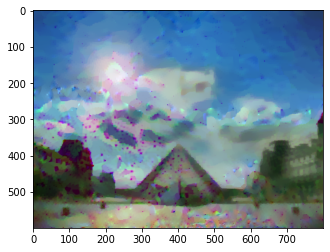

In [55]:
result = plt.imread('output/690.png')
plt.imshow(result)